In [1]:
import numpy as np 
import pandas as pd
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt


def set_dark_mode():
    plt.style.use('dark_background')
    plt.rcParams['axes.facecolor'] = '#121212'
    plt.rcParams['figure.facecolor'] = '#121212'
    plt.rcParams['savefig.facecolor'] = '#121212'
    plt.rcParams['axes.edgecolor'] = 'white'
    plt.rcParams['axes.labelcolor'] = 'white'
    plt.rcParams['xtick.color'] = 'white'
    plt.rcParams['ytick.color'] = 'white'
    plt.rcParams['text.color'] = 'white'
    plt.rcParams['legend.edgecolor'] = 'white'
    plt.rcParams['lines.linewidth'] = 2.0

In [2]:
from dataclasses import dataclass
from typing import List, Dict
import random
from collections import Counter

@dataclass(frozen=True)
class Match:
    home: str
    away: str

def generate_calendar(teams: List[str], seed: int = 42, shuffle_rounds: bool = True) -> List[List[Match]]:
    """
    Circle method (even N):
    - First half: N-1 rounds; in each round i, pair arr[j] vs arr[-1-j].
    - Rotate all except the first team: arr = [arr[0], arr[-1], arr[1], ..., arr[-2]]
    - Second half: mirror (swap home/away) of first half.
    Guarantees: one match/team/round; 19 home + 19 away per team.
    """
    assert len(teams) % 2 == 0, "Number of teams must be even."
    rng = random.Random(seed)
    arr = teams[:]
    rng.shuffle(arr)
    n = len(arr)
    half = n // 2

    rounds_first_half: List[List[Match]] = []
    for r in range(n - 1):
        # Pair fronts with backs
        round_pairs = []
        for j in range(half):
            a = arr[j]
            b = arr[-1 - j]
            # Alternate home/away by round and by pair index to help balance
            if (r + j) % 2 == 0:
                round_pairs.append(Match(home=a, away=b))
            else:
                round_pairs.append(Match(home=b, away=a))
        rounds_first_half.append(round_pairs)

        # Rotate all but the first item: [A, B, C, ..., Y, Z] -> [A, Z, B, C, ..., Y]
        if n > 2:
            arr = [arr[0]] + [arr[-1]] + arr[1:-1]

    # Mirror for second half (swap home/away)
    rounds_second_half = [[Match(home=m.away, away=m.home) for m in rnd] for rnd in rounds_first_half]

    # Optionally shuffle within halves to randomize matchday order (keeps validity)
    if shuffle_rounds:
        rng.shuffle(rounds_first_half)
        rng.shuffle(rounds_second_half)

    season = rounds_first_half + rounds_second_half
    _validate_calendar(season, teams)
    return season

def _validate_calendar(season: List[List[Match]], teams: List[str]) -> None:
    n = len(teams)
    assert len(season) == 2*(n-1), f"Expected {2*(n-1)} rounds, got {len(season)}."
    # Each round: every team appears once
    teamset = set(teams)
    for i, rnd in enumerate(season, 1):
        seen = set()
        for m in rnd:
            assert m.home in teamset and m.away in teamset and m.home != m.away
            assert m.home not in seen and m.away not in seen, f"Team plays twice in round {i}"
            seen.add(m.home); seen.add(m.away)
        assert len(seen) == n, f"Missing teams in round {i}"

    # Home/away exactly n-1 each; each ordered pair exactly once
    home_counts = Counter()
    away_counts = Counter()
    pair_counts = Counter()
    for rnd in season:
        for m in rnd:
            home_counts[m.home] += 1
            away_counts[m.away] += 1
            pair_counts[(m.home, m.away)] += 1

    for t in teams:
        assert home_counts[t] == (n-1), f"{t} home games: {home_counts[t]} != {n-1}"
        assert away_counts[t] == (n-1), f"{t} away games: {away_counts[t]} != {n-1}"

    for a in teams:
        for b in teams:
            if a == b: continue
            assert pair_counts[(a,b)] == 1, f"Pair {a} vs {b} appears {pair_counts[(a,b)]} times"

In [3]:
teams = [f"Team{i:02d}" for i in range(1, 21)]
season = generate_calendar(teams, seed = 2,shuffle_rounds=True)
print(f"Rounds: {len(season)}; Matches total: {sum(len(r) for r in season)} (should be 38 & 380)")
for md in range(2):
    print(f"\nMatchday {md+1}")
    for m in season[md]:
        print(f"{m.home} vs {m.away}")

Rounds: 38; Matches total: 380 (should be 38 & 380)

Matchday 1
Team12 vs Team08
Team19 vs Team06
Team17 vs Team03
Team02 vs Team13
Team11 vs Team07
Team18 vs Team05
Team15 vs Team09
Team20 vs Team10
Team04 vs Team16
Team14 vs Team01

Matchday 2
Team08 vs Team19
Team12 vs Team03
Team02 vs Team06
Team17 vs Team07
Team18 vs Team13
Team11 vs Team09
Team20 vs Team05
Team15 vs Team16
Team14 vs Team10
Team04 vs Team01


In [4]:
from collections import defaultdict
from typing import Tuple

@dataclass
class TeamRow:
    pts: int = 0
    gf: int = 0
    ga: int = 0
    gd: int = 0
    w: int = 0
    d: int = 0
    l: int = 0


# ----------------------------
# Strengths helpers
# ----------------------------
def make_tiered_strengths(teams: List[str]) -> Dict[str, float]:
    """
    Simple, reproducible strengths:
    - Strong top 6, solid next 6, average next 4, weaker bottom 4.
    Values are on a free scale; 0 = league-average.
    """
    # Customize to taste
    tiers = (
        +0.55, +0.45, +0.35, +0.30, +0.25, +0.20,   # top 6
        +0.10, +0.08, +0.06, +0.04, +0.02,  0.00,   # next 6
        -0.02, -0.04, -0.06,                       # next 4
        -0.20, -0.30, -0.45, -0.55                 # bottom 4
    )
    tiers = tiers if len(tiers) >= len(teams) else np.linspace(0.6, -0.6, len(teams))
    strengths = {t: float(tiers[i]) for i, t in enumerate(teams)}
    return strengths

# ----------------------------
# Poisson match model
# ----------------------------
def _poisson(rng: random.Random, lam: float) -> int:
    # Knuth's algorithm (fine for this use)
    L = np.exp(-lam)
    k, p = 0, 1.0
    while p > L:
        k += 1
        p *= rng.random()
    return k - 1

def simulate_match(home: str, away: str, strengths: Dict[str, float],
                   base_rate: float = 1.35, home_adv: float = 0.30,
                   rng: random.Random = None) -> Tuple[int, int, int, int]:
    """
    Returns (home_pts, away_pts, gh, ga)
    """
    if rng is None:
        rng = random.Random()
    s_h = strengths[home]
    s_a = strengths[away]
    xg_h = base_rate * np.exp(home_adv + (s_h - s_a))
    xg_a = base_rate * np.exp(0.0      + (s_a - s_h))
    gh = _poisson(rng, xg_h)
    ga = _poisson(rng, xg_a)

    if gh > ga:
        return 3, 0, gh, ga
    elif ga > gh:
        return 0, 3, gh, ga
    else:
        return 1, 1, gh, ga


In [5]:
import pandas as pd
import numpy as np
from typing import List, Dict, Tuple
from collections import defaultdict

# ---------- Run a season AND keep detailed logs ----------
def simulate_season_with_logs(
    teams: List[str],
    season: List[List[Match]],
    strengths: Dict[str, float],
    base_rate: float = 1.35,
    home_adv: float = 0.30,
    seed: int = 7
) -> Tuple[Dict[str, TeamRow], List[dict]]:
    """
    Returns:
      - table: final TeamRow per team
      - logs: list of dicts, one per match, including matchday & per-team stats
    """
    rng = random.Random(seed)
    table: Dict[str, TeamRow] = {t: TeamRow() for t in teams}
    logs: List[dict] = []

    for md, rnd in enumerate(season, 1):
        for m in rnd:
            p_h, p_a, gh, ga = simulate_match(m.home, m.away, strengths, base_rate, home_adv, rng)

            # update table
            table[m.home].pts += p_h
            table[m.away].pts += p_a
            table[m.home].gf  += gh; table[m.home].ga += ga
            table[m.away].gf  += ga; table[m.away].ga += gh
            if p_h == 3:
                table[m.home].w += 1; table[m.away].l += 1
            elif p_a == 3:
                table[m.away].w += 1; table[m.home].l += 1
            else:
                table[m.home].d += 1; table[m.away].d += 1

            # match-level logs (both perspectives)
            logs.append({
                "matchday": md, "home": m.home, "away": m.away,
                "gh": gh, "ga": ga,
                "pts_home": p_h, "pts_away": p_a
            })

    for t in teams:
        table[t].gd = table[t].gf - table[t].ga

    return table, logs

# ---------- Build tidy dataframes ----------
def build_match_df(logs: List[dict]) -> pd.DataFrame:
    """
    One row per match with basic info and result labels.
    """
    df = pd.DataFrame(logs).sort_values(["matchday", "home"])
    def result(gh, ga):
        if gh > ga: return "H"
        if ga > gh: return "A"
        return "D"
    df["result"] = np.where(df["gh"] > df["ga"], "H", np.where(df["ga"] > df["gh"], "A", "D"))
    return df

def build_team_timeseries_df(teams: List[str], match_df: pd.DataFrame) -> pd.DataFrame:
    """
    Panel time series for forecasting.
    Returns columns:
      unique_id (team), ds (matchday 1..38), y (cumulative points),
      pts (points gained that round), gf, ga, gd (cumulative),
      w,d,l (cumulative), opponent, ha ('H'/'A'), goals_for, goals_against, result
    """
    rows = []
    # Expand to team perspective
    for _, r in match_df.iterrows():
        # Home row
        rows.append({
            "matchday": r.matchday, "team": r.home, "opponent": r.away, "ha": "H",
            "goals_for": r.gh, "goals_against": r.ga,
            "pts": 3 if r.gh > r.ga else (1 if r.gh == r.ga else 0),
            "result": "W" if r.gh > r.ga else ("D" if r.gh == r.ga else "L")
        })
        # Away row
        rows.append({
            "matchday": r.matchday, "team": r.away, "opponent": r.home, "ha": "A",
            "goals_for": r.ga, "goals_against": r.gh,
            "pts": 3 if r.ga > r.gh else (1 if r.ga == r.gh else 0),
            "result": "W" if r.ga > r.gh else ("D" if r.ga == r.gh else "L")
        })

    td = pd.DataFrame(rows).sort_values(["team", "matchday"])
    # Cumulative aggregates per team
    td["cum_pts"] = td.groupby("team")["pts"].cumsum()
    td["cum_gf"]  = td.groupby("team")["goals_for"].cumsum()
    td["cum_ga"]  = td.groupby("team")["goals_against"].cumsum()
    td["cum_gd"]  = td["cum_gf"] - td["cum_ga"]

    # Cumulative W/D/L (nice features if needed)
    td["w1"] = (td["result"] == "W").astype(int)
    td["d1"] = (td["result"] == "D").astype(int)
    td["l1"] = (td["result"] == "L").astype(int)
    td["cum_w"] = td.groupby("team")["w1"].cumsum()
    td["cum_d"] = td.groupby("team")["d1"].cumsum()
    td["cum_l"] = td.groupby("team")["l1"].cumsum()
    td.drop(columns=["w1","d1","l1"], inplace=True)

    # StatsForecast/TimeGPT-ready view
    ts = td.rename(columns={
        "team": "unique_id",
        "matchday": "ds",
        "cum_pts": "y"
    })[[
        "unique_id", "ds", "y",                 # <-- required for many Nixtla pipelines
        "pts", "opponent", "ha",
        "goals_for", "goals_against", "result",
        "cum_gf", "cum_ga", "cum_gd", "cum_w", "cum_d", "cum_l"
    ]]
    ts["ds"] = ts["ds"].astype(int)
    return ts, td

def build_standings_by_round(td: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a tidy standings table for every matchday:
    columns: matchday, pos, team, pts, gd, gf
    """
    # pick cumulative metrics at each round
    snap = td[["matchday", "team", "cum_pts", "cum_gd", "cum_gf"]].copy()
    snap = snap.rename(columns={"cum_pts":"pts", "cum_gd":"gd", "cum_gf":"gf"})
    # rank within each round
    snap["pos"] = snap.groupby("matchday") \
                      .apply(lambda g: g.sort_values(["pts","gd","gf"], ascending=False)
                                      .assign(pos=lambda x: np.arange(1, len(x)+1))) \
                      .reset_index(level=0, drop=True)["pos"]
    return snap.sort_values(["matchday", "pos"]).reset_index(drop=True)

# ---------- One-shot convenience wrapper ----------
def prepare_forecasting_data(
    teams: List[str],
    season: List[List[Match]],
    strengths: Dict[str, float],
    base_rate: float = 1.35,
    home_adv: float = 0.30,
    seed: int = 7,
    cutoff_matchday: int = None
):
    """
    Simulate a season and return:
      - matches_df: one row per match with scores and results
      - ts_df: timeseries dataframe ready for forecasting (columns: unique_id, ds, y, ...)
      - standings_df: positions for every team at every matchday
    If cutoff_matchday is provided (e.g., 20), trims the data to 1..cutoff_matchday (for training)
    and returns 'h' = remaining matchdays (38 - cutoff_matchday) as the forecast horizon.
    """
    final_table, logs = simulate_season_with_logs(
        teams, season, strengths, base_rate=base_rate, home_adv=home_adv, seed=seed
    )
    matches_df = build_match_df(logs)
    ts_df, team_detail_df = build_team_timeseries_df(teams, matches_df)
    standings_df = build_standings_by_round(team_detail_df)

    h = None
    if cutoff_matchday is not None:
        ts_df = ts_df[ts_df["ds"] <= cutoff_matchday].copy()
        standings_df = standings_df[standings_df["matchday"] <= cutoff_matchday].copy()
        h = 38 - int(cutoff_matchday)

    return {
        "matches_df": matches_df,      # match results (one row per match)
        "ts_df": ts_df,                # timeseries for forecasting: unique_id, ds, y (cumulative points)
        "standings_df": standings_df,  # team rankings at each matchday
        "h": h                         # forecast horizon (remaining matchdays) if cutoff was used
    }


In [6]:
teams = [f"Team{i:02d}" for i in range(1, 21)]
season = generate_calendar(teams, seed=2025, shuffle_rounds=True)
strengths = make_tiered_strengths(teams)

# 1) Full season → dataframes for plots + forecasting
full_season_results = prepare_forecasting_data(teams, season, strengths, seed=777)
matches_df = full_season_results["matches_df"]
full_season_ts = full_season_results["ts_df"]  # (unique_id, ds, y) ready for StatsForecast/TimeGPT
standings_df = full_season_results["standings_df"]

# 2) Train on first 20 matchdays, forecast remaining 18
train_data = prepare_forecasting_data(teams, season, strengths, seed=777, cutoff_matchday=35)
train_ts = train_data["ts_df"]  # ds ∈ [1..20]
forecast_horizon = train_data["h"]  # 18 matchdays remaining


In [7]:
print(train_ts.to_markdown())

|     | unique_id   |   ds |   y |   pts | opponent   | ha   |   goals_for |   goals_against | result   |   cum_gf |   cum_ga |   cum_gd |   cum_w |   cum_d |   cum_l |
|----:|:------------|-----:|----:|------:|:-----------|:-----|------------:|----------------:|:---------|---------:|---------:|---------:|--------:|--------:|--------:|
|   0 | Team01      |    1 |   3 |     3 | Team20     | H    |           6 |               0 | W        |        6 |        0 |        6 |       1 |       0 |       0 |
|  20 | Team01      |    2 |   6 |     3 | Team09     | H    |           4 |               1 | W        |       10 |        1 |        9 |       2 |       0 |       0 |
|  40 | Team01      |    3 |   9 |     3 | Team11     | H    |           5 |               1 | W        |       15 |        2 |       13 |       3 |       0 |       0 |
|  60 | Team01      |    4 |  10 |     1 | Team07     | H    |           0 |               0 | D        |       15 |        2 |       13 |       3 |       

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from typing import Optional, Sequence

def _conform_forecast_df(
    fcst: pd.DataFrame,
    team: str,
    ds_col: str = "ds",
    mean_col: Optional[str] = None,
    lo_col: Optional[str] = None,
    hi_col: Optional[str] = None,
    model_name: Optional[str] = None,
    level: Optional[int] = None,
) -> pd.DataFrame:
    """
    Normalize a forecast frame to columns: ds, yhat, yhat_lo, yhat_hi for a single team.

    Works with:
      - Generic frames already named: 'yhat', 'yhat_lo', 'yhat_hi'
      - StatsForecast output (wide): columns like ['AutoARIMA', 'AutoARIMA-lo-80', 'AutoARIMA-hi-80']
      - Any custom naming if you pass mean_col/lo_col/hi_col explicitly.
    """
    g = fcst[fcst["unique_id"] == team].copy()

    # If user specified columns, use them.
    if mean_col:
        g = g.rename(columns={mean_col: "yhat"})
        if lo_col: g = g.rename(columns={lo_col: "yhat_lo"})
        if hi_col: g = g.rename(columns={hi_col: "yhat_hi"})
    else:
        # Try common names
        if "yhat" in g.columns:
            pass
        else:
            # StatsForecast wide format
            # Guess model name if not provided: take the first non-id/ds column
            if model_name is None:
                candidate_cols = [c for c in g.columns if c not in {"unique_id", ds_col}]
                model_name = candidate_cols[0] if candidate_cols else None
            # Guess level if not provided: prefer 95, fall back to 80
            if level is None:
                level = 95 if f"{model_name}-lo-95" in g.columns else (80 if f"{model_name}-lo-80" in g.columns else None)

            mapping = {}
            if model_name and model_name in g.columns:
                mapping[model_name] = "yhat"
            if model_name and level is not None:
                lo_name = f"{model_name}-lo-{level}"
                hi_name = f"{model_name}-hi-{level}"
                if lo_name in g.columns: mapping[lo_name] = "yhat_lo"
                if hi_name in g.columns: mapping[hi_name] = "yhat_hi"
            g = g.rename(columns=mapping)

    keep = ["unique_id", ds_col, "yhat"] + [c for c in ["yhat_lo", "yhat_hi"] if c in g.columns]
    g = g[keep].rename(columns={ds_col: "ds"})
    return g

def plot_team_cumpoints_with_forecast(
    ts_df: pd.DataFrame,
    team: str,
    fcst_df: Optional[pd.DataFrame] = None,
    *,
    ds_col: str = "ds",
    y_col: str = "y",
    mean_col: Optional[str] = None,
    lo_col: Optional[str] = None,
    hi_col: Optional[str] = None,
    model_name: Optional[str] = None,
    level: Optional[int] = None,
    title: Optional[str] = None,
    show: bool = True,
):
    # Actuals (all available ds for the team)
    act = ts_df.loc[ts_df["unique_id"] == team, [ds_col, y_col]].sort_values(ds_col).rename(
        columns={ds_col: "ds", y_col: "y"}
    )

    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.plot(act["ds"].values, act["y"].values, marker="o", linewidth=1.5, label="Actual cum. points")

    # Optional forecast
    if fcst_df is not None and len(fcst_df):
        g = _conform_forecast_df(
            fcst_df, team,
            ds_col=ds_col, mean_col=mean_col, lo_col=lo_col, hi_col=hi_col,
            model_name=model_name, level=level
        )
        # Shade interval if present
        if {"yhat_lo", "yhat_hi"}.issubset(g.columns):
            ax.fill_between(g["ds"].values, g["yhat_lo"].values, g["yhat_hi"].values, alpha=0.2, label="Prediction interval", color = 'lime')

        ax.plot(g["ds"].values, g["yhat"].values, linestyle="--", linewidth=1.8, label="Forecast mean", color = 'lime')

        # Draw a vertical line at the last observed ds (split point)
        if len(act):
            split = 36
            ax.axvline(split, linestyle=":", alpha=0.6)
            ax.text(split, ax.get_ylim()[1], " Train/Forecast Split", va="top", ha="left", fontsize=9)

    ax.set_xlabel("Match Day Number", fontsize = 15)
    ax.set_ylabel("Championship Points", fontsize = 15)
    ax.set_title(title or f"{team}: Championship Points & Forecast", fontsize = 15)
    ax.grid(True, alpha=0.25)
    ax.legend(loc="best", fontsize = 15)
    if show:
        plt.savefig('/Users/pieropaialunga/Desktop/blog/images/championship_forecasting/title-image.svg')
        plt.show()
    return fig, ax


def round_forecast_to_valid_points(forecast_df: pd.DataFrame) -> pd.DataFrame:
    """
    Round forecast values to integers since football points must be whole numbers.
    
    In football, you can only earn 0, 1 (draw), or 3 (win) points per match.
    Therefore, cumulative points must always be integers.
    
    This function rounds all forecast columns (mean, lower/upper bounds) to the nearest integer.
    """
    df = forecast_df.copy()
    for col in df.columns:
        if col not in ['unique_id', 'ds']:
            df[col] = df[col].round().astype(int)
    return df

In [ ]:

train

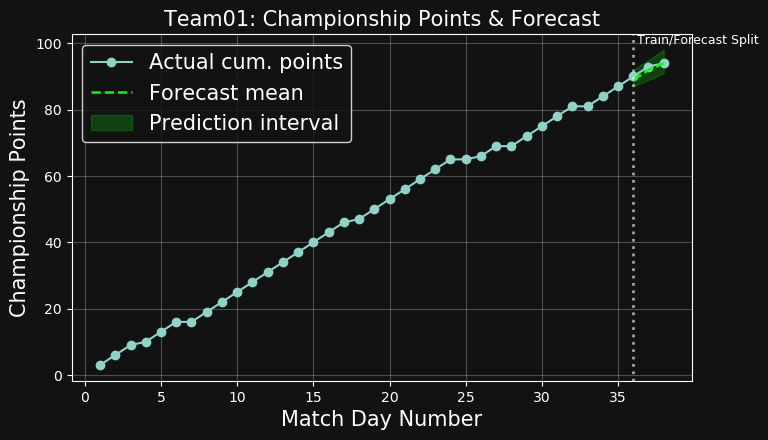

(<Figure size 800x450 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x147a3dbd0>)

In [10]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

# Train up to matchday 35, forecast remaining rounds
train_data = prepare_forecasting_data(teams, season, strengths, seed=777, cutoff_matchday=35)
train_ts = train_data["ts_df"][["unique_id","ds","y"]]
forecast_horizon = train_data["h"]

sf = StatsForecast(models=[AutoARIMA()], freq=1)
sf.fit(train_ts)

# StatsForecast returns a wide frame: ['unique_id','ds','AutoARIMA','AutoARIMA-lo-95','AutoARIMA-hi-95'] if level=[95]
forecast_raw = sf.predict(h=forecast_horizon, level=[95])

# Round to valid integer points (football only allows 0, 1, or 3 points per match)
forecast = round_forecast_to_valid_points(forecast_raw)

# Add actual values to compare with predictions
full_season_results = prepare_forecasting_data(teams, season, strengths, seed=777)
full_season_ts = full_season_results["ts_df"][["unique_id", "ds", "y"]]

# Merge actual values into the forecast dataframe
forecast = forecast.merge(
    full_season_ts.rename(columns={"y": "actual"}),
    on=["unique_id", "ds"],
    how="left"
)
set_dark_mode()
plot_team_cumpoints_with_forecast(
    ts_df=full_season_results["ts_df"],  # full actuals for context
    team="Team01",
    fcst_df=forecast,
    model_name="AutoARIMA",  # tell the helper how to read the wide columns
    level=95
)


In [11]:
# Display forecast vs actual for one team
team_to_check = "Team20"
team_forecast = forecast[forecast["unique_id"] == team_to_check].copy()

# Calculate error if we have actuals
if "actual" in team_forecast.columns:
    team_forecast["error"] = team_forecast["AutoARIMA"] - team_forecast["actual"]
    team_forecast["abs_error"] = team_forecast["error"].abs()

print(f"\nForecast vs Actual for {team_to_check}:")
team_forecast[["ds", "AutoARIMA", "actual", "error", "AutoARIMA-lo-95", "AutoARIMA-hi-95"]]



Forecast vs Actual for Team20:


,ds,AutoARIMA,actual,error,AutoARIMA-lo-95,AutoARIMA-hi-95
57,36,20,19,1,18,21
58,37,20,19,1,17,23
59,38,21,19,2,17,24


In [12]:
# Calculate overall forecast accuracy metrics
if "actual" in forecast.columns:
    forecast["error"] = forecast["AutoARIMA"] - forecast["actual"]
    forecast["abs_error"] = forecast["error"].abs()
    forecast["squared_error"] = forecast["error"] ** 2
    
    print("\n=== Forecast Accuracy Metrics ===")
    print(f"Mean Absolute Error (MAE): {forecast['abs_error'].mean():.2f} points")
    print(f"Root Mean Squared Error (RMSE): {np.sqrt(forecast['squared_error'].mean()):.2f} points")
    print(f"Mean Error (bias): {forecast['error'].mean():.2f} points")
    
    # Check prediction interval coverage
    in_interval = (
        (forecast["actual"] >= forecast["AutoARIMA-lo-95"]) & 
        (forecast["actual"] <= forecast["AutoARIMA-hi-95"])
    )
    coverage = in_interval.mean() * 100
    print(f"95% Prediction Interval Coverage: {coverage:.1f}% (should be ~95%)")
    
    # Show worst predictions
    print("\n=== Top 5 Worst Predictions (by absolute error) ===")
    worst = forecast.nlargest(5, 'abs_error')[["unique_id", "ds", "AutoARIMA", "actual", "error"]]
    print(worst.to_string(index=False))



=== Forecast Accuracy Metrics ===
Mean Absolute Error (MAE): 1.67 points
Root Mean Squared Error (RMSE): 1.97 points
Mean Error (bias): 0.13 points
95% Prediction Interval Coverage: 98.3% (should be ~95%)

=== Top 5 Worst Predictions (by absolute error) ===
unique_id  ds  AutoARIMA  actual  error
   Team09  38         45      50     -5
   Team09  37         43      47     -4
   Team11  37         46      50     -4
   Team16  38         35      31      4
   Team06  38         71      74     -3


In [13]:
print(forecast.to_markdown())

|    | unique_id   |   ds |   AutoARIMA |   AutoARIMA-lo-95 |   AutoARIMA-hi-95 |   actual |   error |   abs_error |   squared_error |
|---:|:------------|-----:|------------:|------------------:|------------------:|---------:|--------:|------------:|----------------:|
|  0 | Team01      |   36 |          89 |                87 |                92 |       90 |      -1 |           1 |               1 |
|  1 | Team01      |   37 |          92 |                89 |                95 |       93 |      -1 |           1 |               1 |
|  2 | Team01      |   38 |          94 |                91 |                98 |       94 |       0 |           0 |               0 |
|  3 | Team02      |   36 |          83 |                81 |                85 |       84 |      -1 |           1 |               1 |
|  4 | Team02      |   37 |          86 |                83 |                89 |       87 |      -1 |           1 |               1 |
|  5 | Team02      |   38 |          88 |              